In [82]:
import numpy as np
import tensorflow as tf
import pandas as pd
import librosa
import librosa.display
import os.path as p
import os
import matplotlib.pyplot as plt
from IPython.display import display # to display images
import IPython.display as ipd

%matplotlib inline
datasource_path = "UrbanSound8K"
audio_source = p.join(datasource_path, "audio")
metadata_path = p.join(p.join(datasource_path, "metadata"),"UrbanSound8K.csv")
metadata = pd.read_csv(metadata_path, index_col="fsID")
spectro_path = p.join("UrbanSound8k", "spectrogram")
folds = ["fold{}".format(str(i)) for i in range(1,11)]

In [83]:
import gc


def build_path(file_name,spectrogram = False):
    file= file_name.split(".")
    source = spectro_path if spectrogram else audio_source
    file_name = file[0] + ".jpg" if spectrogram else file[0] +".wav"
    fsID= int(file_name.split("-")[0])
    frame = metadata.loc[fsID]
    fold_id = 0
    try:
        fold_id = frame["fold"].values[0]-1
    except:
        fold_id = frame["fold"] -1
    file_with_fold = p.join(folds[fold_id], file_name)
    return p.join(source,file_with_fold), fold_id

In [111]:
metadata[:5]

,slice_file_name,start,end,salience,fold,classID,class
fsID,,,,,,,
100032,100032-3-0-0.wav,0.0,0.317551,1,5,3,dog_bark
100263,100263-2-0-117.wav,58.5,62.500000,1,5,2,children_playing
100263,100263-2-0-121.wav,60.5,64.500000,1,5,2,children_playing
100263,100263-2-0-126.wav,63.0,67.000000,1,5,2,children_playing
100263,100263-2-0-137.wav,68.5,72.500000,1,5,2,children_playing


In [143]:
def load_image( infilename, height,width) :
    img = Image.open(infilename).resize((width, height))
    return np.expand_dims(img,axis=0)

def preprocess_sound(path):
    clip, sample_rate = librosa.load(path, sr=None)
    
    return librosa.power_to_db(librosa.feature.melspectrogram(y=clip, sr=sample_rate), ref=np.max)

def create_spectrogram(S):
    plt.interactive(False)
    fig = plt.figure(figsize=[0.72,0.72])
    ax = fig.add_subplot(111)
    ax.axes.get_xaxis().set_visible(False)
    ax.axes.get_yaxis().set_visible(False)
    ax.set_frame_on(False)
    librosa.display.specshow(S)
    if not p.exists("tmp"): os.mkdir("tmp")
    savefile  = "tmp/last.jpg"
    plt.savefig(savefile, dpi=400, bbox_inches='tight',pad_inches=0)
    plt.close()    
    fig.clf()
    plt.close(fig)
    plt.close('all')
    del fig,ax,S
    return savefile

def interpret(spectro_path):
    interpreter = tf.lite.Interpreter(model_path="model.tflite")
    interpreter.allocate_tensors()

    # Get input and output tensors.
    input_details = interpreter.get_input_details()
    output_details = interpreter.get_output_details()

    height = input_details[0]['shape'][1]
    width = input_details[0]['shape'][2]
    input_data = load_image(spectro_path, height, width)
    
    floating_model = input_details[0]['dtype'] == np.float32
    if floating_model:
        input_data = (np.float32(input_data) - 127.5) / 127.5
    
    input_shape = input_details[0]['shape']
    interpreter.set_tensor(input_details[0]['index'], input_data)

    interpreter.invoke()

    output_data = interpreter.get_tensor(output_details[0]['index'])
    results = np.squeeze(output_data)
    
    for i,val in enumerate(results):
        if floating_model:
            print('{:08.6f}: {}'.format(float(val), labels[i]))
        else:
            print('{:08.6f}: {}'.format(float(val / 255.0), labels[i]))

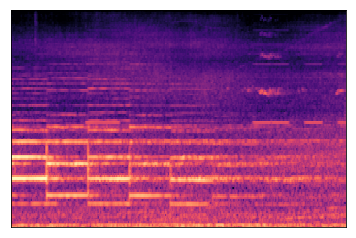

0.987874: air_conditioner
0.000000: car_horn
0.011870: children_playing
0.000119: dog_bark
0.000000: drilling
0.000008: engine_idling
0.000000: gun_shot
0.000000: jackhammer
0.000126: siren
0.000003: street_music


In [144]:
labels = ["air_conditioner", "car_horn", "children_playing", "dog_bark", "drilling",
         "engine_idling", "gun_shot","jackhammer", "siren", "street_music"]


audio_md = metadata.iloc[525]
audio_path, _ = build_path(audio_md["slice_file_name"])

s = preprocess_sound(audio_path)
plt.show(librosa.display.specshow(s))
last = create_spectrogram(s)
interpret(last)

ipd.Audio(audio_path)
